In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from my_ANN import *

In [2]:
data = scipy.io.loadmat('data.mat')

In [3]:
for i in data.keys():
    if isinstance(data[i], np.ndarray):
        print(i, ':', data[i].shape)
    else:
        print(i)

__header__
__version__
__globals__
X : (211, 2)
y : (211, 1)
yval : (200, 1)
Xval : (200, 2)


In [4]:
train_X, train_Y = data['X'].T, data['y'].T
test_X, test_Y = data['Xval'].T, data['yval'].T

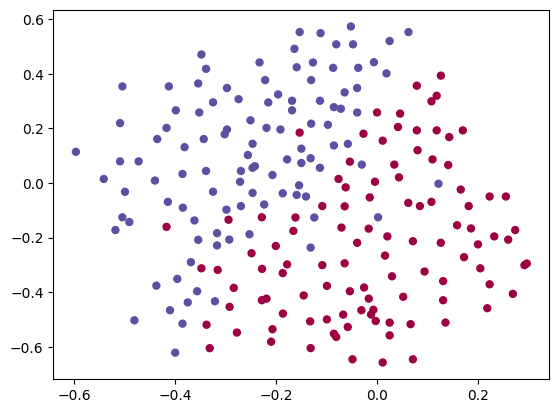

In [5]:
plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=25, cmap=plt.cm.Spectral)

# Forward Pass with Dropout

In [6]:
def forward_with_DropOut(X, params, threshold_to_keep):
    A = X  # X is the initial A
    L = len(params) // 2  # each hidden layer and output layer linked with 2 params W, B

    np.random.seed(1)
    caches = []
    masks = []
    
    # Forward Pass in Hidden Layers
    for i in range(1, L): 
        A_prev = A
        W, B = params[f'W{i}'], params[f'B{i}']
        A, cache = forward_through_activation(A_prev, W, B, activation='relu')
  
        dropOut_mask = np.random.rand(A.shape[0], A.shape[1])  # range [0, 1)
        dropOut_mask = (dropOut_mask < threshold_to_keep).astype('int')
        A = A * dropOut_mask
        A = A / threshold_to_keep
        
        caches.append(cache)
        masks.append(dropOut_mask)
        
    # Forward Pass in Output Layer
    W, B = params[f'W{L}'], params[f'B{L}']
    Y_pred, cache = forward_through_activation(A, W, B, activation='sigmoid')
    Y_pred = np.clip(Y_pred, 1e-7, 1 - 1e-7)  # To prevent taking the logarithm of 0 or division by 0
    caches.append(cache)

    return Y_pred, caches, dropOut_mask

# Back-Propagation with Dropout

In [7]:
def backward_with_DropOut(Y, Y_pred, caches, threshold_to_keep, masks):  # Y shape (n_samples, )
    grads = {}
    L = len(caches)
    
    ###
    Y = Y.reshape(Y_pred.shape)  # Y and Y_pred must have the same shape (1, n_samples)
    dY_pred = backward_through_costFunc(Y, Y_pred, cost_func='binary_cross_entropy')
    
    ###
    last_cache = caches[-1]  # cache[L-1]
    last_mask = masks[-1]
    
    dA_prev, dW, dB = backward_each_layer(dY_pred, last_cache, activation='sigmoid')
    dA_prev = dA_prev * last_mask
    dA_prev = dA_prev / threshold_to_keep
    
    grads[f'dA{L-1}'] = dA_prev
    grads[f'dW{L}'] = dW
    grads[f'dB{L}'] = dB

    ###
    for i in range(L-1, 0, -1):  # from L-1 to 1
        dA = dA_prev
        current_cache = caches[i-1]  # from cache[L-2] to cache[0]
        current_mask = masks[i-1]
        
        dA_prev, dW, dB = backward_each_layer(dA, current_cache, activation='relu')
        dA_prev = dA_prev * current_mask
        dA_prev = dA_prev / threshold_to_keep
        
        grads[f'dA{i-1}'] = dA_prev  # to dA0
        grads[f'dW{i}'] = dW
        grads[f'dB{i}'] = dB

    return grads

# Model with Dropout

In [8]:
def my_model(X_train, Y_train, layers, learning_rate=0.01, iterations=3000, threshold_to_keep=1):
    costs = []

    np.random.seed(3)
    params = initialize_params(layers)
    
    # training
    for i in range(1, iterations+1):
        # forward pass
        Y_pred, caches, masks = forward_with_DropOut(X_train, params, threshold_to_keep)
        # compute cost
        cost = compute_cost(Y_pred, Y_train)
        if i % 100 == 0 or i == 1:
            costs.append(cost)
        # backward pass to compute gradients
        grads = backward_with_DropOut(Y_train, Y_pred, caches, threshold_to_keep, masks)
        # update parameters
        params = update_params(params, grads, learning_rate)

        # print cost
        if i % 5000 == 0 or i == 1:
            print('Cost after Iteration {}: {}'.format(i, cost))

    return params, costs

In [9]:
def plot_costs(costs, title):
    plt.figure(figsize=(4,3))
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations (x100)')
    plt.title(title)
    plt.show()

In [10]:
def plot_decision_boundary(X, y, params):
    """
    X: (n_features, n_samples)
    Y: (1, n_samples)
    """
    x1_min, x1_max = X[0, :].min() - 1, X[0, :].max() + 1
    x2_min, x2_max = X[1, :].min() - 1, X[1, :].max() + 1
    step = 0.01
    
    x1, x2 = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))
    
    Y_pred = predict(np.c_[x1.ravel(), x2.ravel()].T, params)  # Y_pred shape (1, -1)
    Y_pred = Y_pred.reshape(x1.shape)
    
    plt.contourf(x1, x2, Y_pred, cmap=plt.cm.Spectral, alpha=0.5)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral, alpha=0.7)
    plt.show()

# Training

In [11]:
units_each_layer = [train_X.shape[0], 20, 3, 1]

In [12]:
learning_rate = 0.1

In [13]:
iterations = 30000

### No Dropout

In [14]:
params_no_dropOut, costs_no_dropOut = my_model(train_X, train_Y, 
                                          layers=units_each_layer, 
                                          learning_rate=learning_rate, 
                                          iterations=iterations,
                                          threshold_to_keep=1)

Cost after Iteration 1: 0.6557412523481002
Cost after Iteration 5000: 0.2027070804717822
Cost after Iteration 10000: 0.17904382345303377
Cost after Iteration 15000: 0.17299484231939802
Cost after Iteration 20000: 0.16934083264119318
Cost after Iteration 25000: 0.1649523828105879
Cost after Iteration 30000: 0.15917419109387573


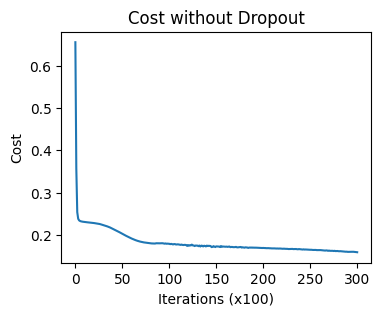

In [15]:
plot_costs(costs_no_dropOut, title="Cost without Dropout")

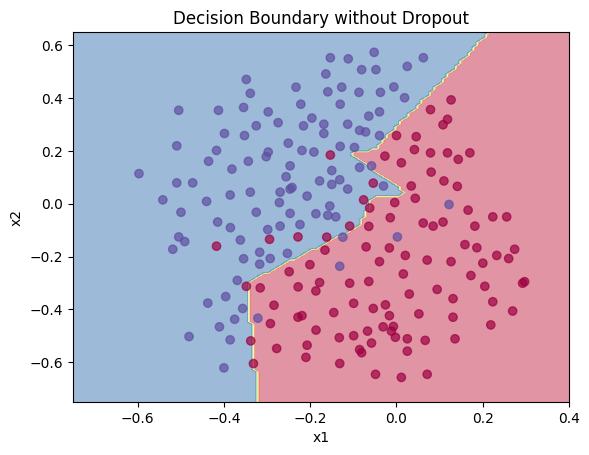

In [16]:
plt.title("Decision Boundary without Dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(train_X, train_Y, params_no_dropOut)

### Lower Dropout Rate

In [17]:
lower_dropOut_rate = 0.1
params_less_dropOut, costs_less_dropOut = my_model(train_X, train_Y, 
                                          layers=units_each_layer, 
                                          learning_rate=learning_rate, 
                                          iterations=iterations,
                                          threshold_to_keep=1-lower_dropOut_rate)

Cost after Iteration 1: 0.6553135664476918
Cost after Iteration 5000: 0.2554820582965103
Cost after Iteration 10000: 0.235252666379958
Cost after Iteration 15000: 0.21946488947104653
Cost after Iteration 20000: 0.21297216244020198
Cost after Iteration 25000: 0.20225395503827093
Cost after Iteration 30000: 0.19714654181227698


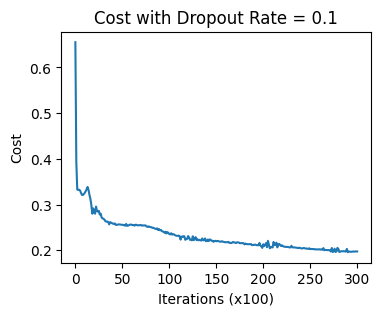

In [18]:
plot_costs(costs_less_dropOut, title="Cost with Dropout Rate = {}".format(lower_dropOut_rate))

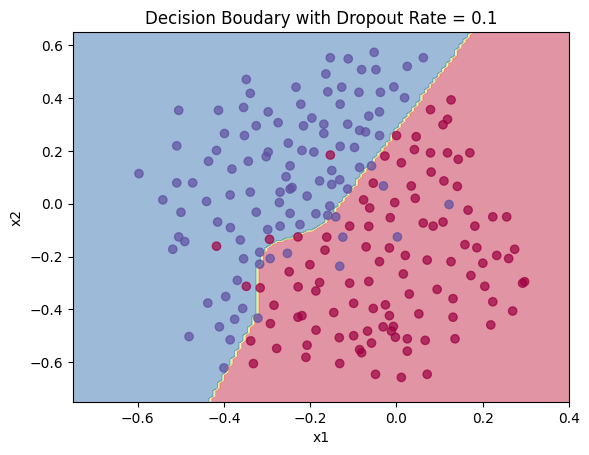

In [19]:
plt.title("Decision Boudary with Dropout Rate = {}".format(lower_dropOut_rate))
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(train_X, train_Y, params_less_dropOut)

### Higher Dropout Rate

In [20]:
higher_dropOut_rate = 0.2
params_more_dropOut, costs_more_dropOut = my_model(train_X, train_Y, 
                                          layers=units_each_layer, 
                                          learning_rate=learning_rate, 
                                          iterations=iterations,
                                          threshold_to_keep=1-higher_dropOut_rate)

Cost after Iteration 1: 0.6565719707512621
Cost after Iteration 5000: 0.4105844740561462
Cost after Iteration 10000: 0.4257088749713083
Cost after Iteration 15000: 0.34392237207438003
Cost after Iteration 20000: 0.31449755932848705
Cost after Iteration 25000: 0.2978958547101631
Cost after Iteration 30000: 0.2793472795474918


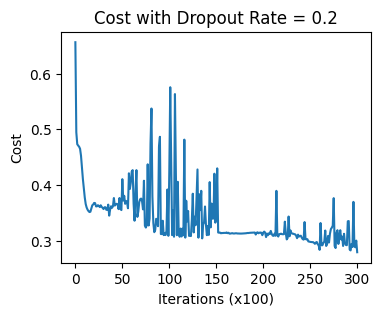

In [21]:
plot_costs(costs_more_dropOut, title="Cost with Dropout Rate = {}".format(higher_dropOut_rate))

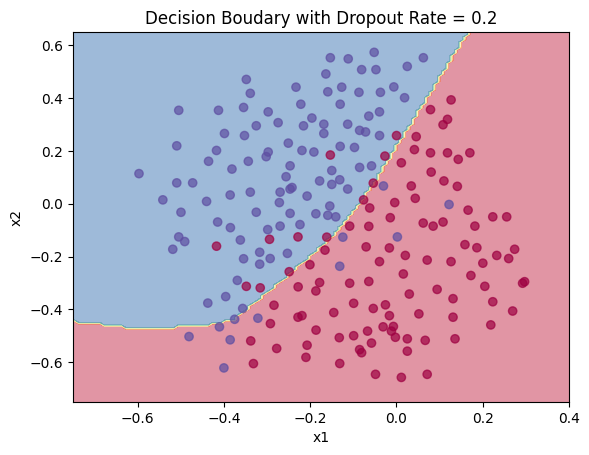

In [22]:
plt.title("Decision Boudary with Dropout Rate = {}".format(higher_dropOut_rate))
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(train_X, train_Y, params_more_dropOut)